# Восстановление золота из руды

## Содержание

* 1  Постановка задачи
* 2  Изучение и подготовка данных
    * 2.1  Изучение данных
    * 2.2  Проверка эффективности обогащения
    * 2.3  Анализ признаков, недоступных в тестовой выборке
    * 2.4  Предобработка данных
* 3  Анализ данных
    * 3.1  Анализ изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки.
    * 3.2  Сравнение распределения гранул сырья на обучающей и тестовых выборках
    * 3.3  Исследование суммарной концентрации веществ
* 4  Модель
    * 4.1  Создание функции для вычисления итоговой sMAPE
    * 4.2  Обучение моделей

## 1 Постановка задачи

Подготовьте прототип модели машинного обучения компании, которая разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.

**Стадии**
1. *Флотация*
<br>Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).

2. *Очистка*
<br>Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

**Описание данных**
    
*Технологический процесс*

* *Rougher feed* — исходное сырье
* *Rougher additions (или reagent additions)* — флотационные реагенты: Xanthate, Sulphate, Depressant
    - Xanthate — ксантогенат (промотер, или активатор флотации);
    - Sulphate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия).
* *Rougher process* (англ. «грубый процесс») — флотация
* *Rougher tails* — отвальные хвосты
* *Float banks* — флотационная установка
* *Cleaner process* — очистка
* *Rougher Au* — черновой концентрат золота
* *Final Au* — финальный концентрат золота

**Параметры этапов**
* *air amount* — объём воздуха
* *fluid levels* — уровень жидкости
* *feed size* — размер гранул сырья
* feed rate*  — скорость подачи

**Наименование признаков**
*Наименование признаков должно быть такое:*

[этап].[тип_параметра].[название_параметра]
Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:
- *rougher* — флотация
- *primary_cleaner* — первичная очистка
- *secondary_cleaner* — вторичная очистка
- *final* — финальные характеристики

Возможные значения для блока [тип_параметра]:
- *input* — параметры сырья
- *output* — параметры продукта
- *state* — параметры, характеризующие текущее состояние этапа
- *calculation* — расчётные характеристики

Необходимо:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Эффективность обогащения расчитывается по следующей формуле:

$$Recovery = \frac{C × (F - T)}{F × (C - T)}$$

где:
* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

В качетстве метрики качетсва применяется sMAPE (Symmetric Mean Absolute Percentage Error), которая вычисляется по формуле:

$$sMAPE = \frac{1}{N} × \sum_{i=1}^{N}\frac{|y_{i} - \stackrel{\land}{y_{i}}|}{(|y_{i}| + |\stackrel{\land}{y_{i}}|)/2}$$

где:

$y_{i}$ - значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество;

$\stackrel{\land}{y_{i}}$ - значение предсказания для объекта с порядковым номером i, например, в тестовой выборке;

N - количество объектов в выборке

Итоговая метрика складывается из двух величин:

$$Итоговое sMAPE = 0.25 × sMAPE(rougher) + 0.75 × sMAPE(final)$$

## 2 Изучение и подготовка данных

In [2]:
import pandas as pd 
from IPython.display import display #импортируем метод дисплей для красивого вывода таблиц (не применяя print)
pd.set_option('display.max_columns', None) #реализуем возможность вывода всех столбцов на экран
pd.set_option('display.float_format', '{:.3f}'.format) #выаодим значения float до 3 знаков после запятой

from sklearn.model_selection import train_test_split # деление на 2 выборки

from sklearn.preprocessing import StandardScaler # для масштабирования количественных признаков

from sklearn.model_selection import GridSearchCV # для поиска оптимальных параметров
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error # для расчета MSE и RMSE
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression # линейная регрессия
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from scipy import stats as st # для доверительного интервала
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

### 2.1 Изучение данных

Загрузим датасеты и выведем по 5 строк в каждом из них.

In [3]:
df_train = pd.read_csv('gold_recovery_train.csv', sep=',', parse_dates = ['date'])
df_test = pd.read_csv('gold_recovery_test.csv', sep=',', parse_dates = ['date'])
df_full = pd.read_csv('gold_recovery_full.csv', sep=',', parse_dates = ['date'])
display(df_full.head())
display(df_train.head())
display(df_test.head())

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055,9.890,5.507,42.192,70.541,10.412,0.895,16.904,2.143,127.092,10.128,7.250,0.989,8.548,10.390,19.529,34.174,14.937,2.535,7.476,2.107,1549.776,-498.912,1551.434,-516.403,1549.874,-498.667,1554.367,-493.428,41885.707,3481.779,3520.337,2.839,6.100,2.285,523.546,55.487,36.809,6.486,11.987,6.008,11.837,6.006,11.501,7.101,28.029,19.794,87.108,5.008,0.509,19.154,1.170,999.707,-404.067,1603.011,-434.715,1602.375,-442.204,1598.937,-451.294,1404.472,-455.463,1416.355,-451.940,14.500,4.695,8.765,2.606,25.853,-498.526,23.894,-501.406,23.962,-495.263,21.940,-499.341,14.017,-502.488,12.100,-504.716,9.926,-498.310,8.080,-500.471,14.151,-605.842
1,2016-01-15 01:00:00,6.029,9.969,5.258,42.702,69.266,10.463,0.927,16.635,2.225,125.629,10.296,7.250,1.003,8.559,10.497,19.369,34.119,16.251,3.050,6.734,2.353,1576.167,-500.905,1575.951,-499.866,1575.994,-499.315,1574.479,-498.932,42050.862,3498.371,3489.982,2.859,6.161,2.266,525.291,57.279,35.753,6.479,11.971,6.006,11.996,6.013,11.616,7.279,28.067,20.051,86.843,4.955,0.537,18.965,1.185,1000.286,-400.065,

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055,9.890,5.507,42.192,70.541,10.412,0.895,16.904,2.143,127.092,10.128,7.250,0.989,8.548,10.390,19.529,34.174,14.937,2.535,7.476,2.107,1549.776,-498.912,1551.434,-516.403,1549.874,-498.667,1554.367,-493.428,41885.707,3481.779,3520.337,2.839,6.100,2.285,523.546,55.487,36.809,6.486,11.987,6.008,11.837,6.006,11.501,7.101,28.029,19.794,87.108,5.008,0.509,19.154,1.170,999.707,-404.067,1603.011,-434.715,1602.375,-442.204,1598.937,-451.294,1404.472,-455.463,1416.355,-451.940,14.500,4.695,8.765,2.606,25.853,-498.526,23.894,-501.406,23.962,-495.263,21.940,-499.341,14.017,-502.488,12.100,-504.716,9.926,-498.310,8.080,-500.471,14.151,-605.842
1,2016-01-15 01:00:00,6.029,9.969,5.258,42.702,69.266,10.463,0.927,16.635,2.225,125.629,10.296,7.250,1.003,8.559,10.497,19.369,34.119,16.251,3.050,6.734,2.353,1576.167,-500.905,1575.951,-499.866,1575.994,-499.315,1574.479,-498.932,42050.862,3498.371,3489.982,2.859,6.161,2.266,525.291,57.279,35.753,6.479,11.971,6.006,11.996,6.013,11.616,7.279,28.067,20.051,86.843,4.955,0.537,18.965,1.185,1000.286,-400.065,

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.801,14.993,8.080,1.005,1398.981,-500.226,1399.145,-499.920,1400.103,-500.704,1399.002,-499.485,13.129,5.637,489.794,62.710,42.022,12.084,16.923,6.153,16.868,6.151,1001.849,-350.301,1249.739,-399.108,1249.751,-399.397,1198.288,-399.489,999.472,-399.531,949.566,-398.181,24.938,-500.491,14.948,-500.014,20.018,-450.396,13.987,-449.832,12.024,-497.796,8.017,-501.289,7.947,-432.318,4.873,-500.037,26.706,-499.709
1,2016-09-01 01:59:59,215.392,14.987,8.080,0.990,1398.778,-500.057,1398.055,-499.778,1396.151,-499.240,1399.508,-500.416,13.036,5.526,490.105,61.961,41.188,11.919,17.003,5.999,16.996,6.002,998.691,-350.426,1248.395,-399.946,1249.514,-399.631,1200.506,-399.942,1000.002,-399.492,950.200,-405.788,24.923,-499.814,14.931,-500.764,19.989,-450.114,14.093,-450.059,12.058,-498.696,8.131,-499.634,7.958,-525.840,4.879,-500.162,25.020,-499.819
2,2016-09-01 02:59:59,215.260,12.885,7.787,0.996,1398.494,-500.868,1398.860,-499.765,1398.076,-502.152,1399.497,-499.715,13.138,5.427,489.618,66.904,42.546,12.091,16.993,5.851,16.982,5.854,998.517,-349.784,1247.441,-400.264,1248.207,-401.074,1199.770,-400.791,999.926,-399.237,950.320,-400.864,24.909,-500.304,14.997,-500.994,20.040,-450.263,14.078,-449.661,11.962,-498.767,8.097,-500.827,8.071,-500.802,4.905,-499.829,24.995,-500.623
3,2016-09-01 03:59:59,215.336,12.007,7.640,0.864,1399.618,-498.864,1397.440,-499.211,1400.129,-498.356,1401.065,-501.039,12.401,5.115,476.618,59.866,41.060,12.182,16.532,5.802,16.515,5.804,1000.277,-350.173,1251.323,-398.655,1250.494,-399.747,1199.399,-397.503,1001.931,-400.438,950.735,-399.803,24.894,-499.382,14.917,-499.862,20.031,-449.373,14.014,-449.527,12.033,-498.351,8.075,-499.474,7.897,-500.869,4.931,-499.964,24.949,-498.710
4,2016-09-01 04:59:59,199.099,10.683,7.530,0.806,1401.268,-500.808,1398.129,-499.505,1402.172,-500.811,1399.481,-499.374,11.327,4.767,488.248,63.315,41.269,11.290,13.607,5.738,13.650,5.740,996.541,-350.563,1304.659,-399.512,1306.456,-399.051,1248.699,-400.877,1058.839,-398.988,949.645,-399.278,24.887,-499.357,14.979,-500.187,19.962,-450.639,14.009,-450.022,12.025,-500.786,8.

Посмотрим какие столбцы и в каком количестве имеются в датасетах.

In [4]:
print(len(df_full.columns))
df_full.columns

87


Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

In [5]:
print(len(df_train.columns))
df_train.columns

87


Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

In [5]:
print(len(df_test.columns))
df_test.columns

53


Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

Видим, что в тестовой выборке отсутствует ряд признаков, которые замеряются и/или рассчитываются значительно позже. Также в тестовой выборке отсутствуют целевые признаки *final.output.recovery* и *rougher.output.recovery*. При создании модели лишние признаки не должны быть включены в обучающие. Но далее они нам понадобятся для исследовательского анализа данных.

In [6]:
print(df_full.info())
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                22716 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         22627 non-null  float64       
 2   final.output.concentrate_pb                         22629 non-null  float64       
 3   final.output.concentrate_sol                        22331 non-null  float64       
 4   final.output.concentrate_au                         22630 non-null  float64       
 5   final.output.recovery                               20753 non-null  float64       
 6   final.output.tail_ag                                22633 non-null  float64       
 7   final.output.tail_pb                                22516 non-null  float64       
 8   final.

Во всех таблицах имеются пропуски в различных столбцах (кроме столбца с датой - он везде заполнен), предполагаем, что больше всего информации содержится в датасете full, поэтому при предобработке данных следует попытаться записать недостающие данные в трейн и тест именно из него. За определяющий столбец при этом примем дату и время снятия данных.

Посмотрим описание числовых харктеристик каждой таблицы.

In [7]:
df_full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000,22629.000,22331.000,22630.000,20753.000,22633.000,22516.000,22445.000,22635.000,21107.000,21170.000,22716.000,21565.000,22618.000,22268.000,21918.000,22618.000,22614.000,22594.000,22365.000,22617.000,22660.000,22667.000,22660.000,22673.000,22662.000,22673.000,22661.000,22673.000,22672.000,22672.000,22672.000,21089.000,22618.000,22472.000,22163.000,22277.000,22357.000,22617.000,21415.000,22247.000,22038.000,20459.000,22618.000,22618.000,22526.000,22618.000,19597.000,19979.000,22618.000,19980.000,19980.000,22646.000,22647.000,22646.000,22647.000,22646.000,22654.000,22641.000,22649.000,22096.000,22649.000,22641.000,22642.000,22616.000,22600.000,20501.000,22618.000,22333.000,22591.000,22538.000,22588.000,22585.000,22587.000,22592.000,22590.000,22571.000,22587.000,22608.000,22607.000,22615.000,22615.000,22615.000,22616.000,22597.000,22615.000
mean,4.782,9.095,8.640,40.001,67.447,8.924,2.488,9.524,2.827,140.278,8.588,7.289,0.970,7.692,8.921,9.574,29.212,14.876,3.176,7.208,3.670,1511.163,-506.648,1514.352,-508.479,1502.534,-507.776,1473.186,-504.125,-6

Основная задача в рассмотрении числовых характеристик это посмотреть граничные значения и определить влияние выбросов на выборки признаков. Это влияние проявляется в сильном различии медианны и среднего.
Для полного датасета влияние выбросов проявляется для следующих столбцов: rougher.calculation.sulfate_to_au_concentrate, rougher.calculation.floatbank10_sulfate_to_au_feed, rougher.calculation.floatbank11_sulfate_to_au_feed. Для всех указанных столбцов имеются большие отрицательные выбросы, но так как данные столбцы не используются в тестовой выборке, то они также не будут использоваться в обучающей выборке, в связи с чем заострять на них особое внимание не будем.

Также замечено, что для ряда столбцов является нормальным наличие отрицательных значений. Такими столбцами являются признаки технологического процесса, - уровень и давление воздуха. Для данных двух параметров допустимо наличие отрицательных значений: для уровня - нулевое значение может соответствовать какому-либо нормированному состоянию наполнения емкости (например, в стандартном состоянии должна быть заполнена на половину), а для давления - отрицательным значением является возникающее противодавление.

Дополнительно видно, что в целевых признаках имеются нулевые значения, что недопустимо, т.к. это говорит, что процесс прошел абсолютно бесполезно. Такие значения необходимо будет удалить из датасетов.

In [8]:
df_train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000,16788.000,16490.000,16789.000,15339.000,16794.000,16677.000,16715.000,16794.000,15553.000,15598.000,16860.000,15875.000,16778.000,16502.000,16224.000,16778.000,16777.000,16761.000,16579.000,16777.000,16820.000,16827.000,16820.000,16833.000,16822.000,16833.000,16821.000,16833.000,16833.000,16833.000,16833.000,15618.000,16778.000,16632.000,16347.000,16443.000,16568.000,16777.000,15816.000,16514.000,16237.000,14956.000,16778.000,16778.000,16698.000,16778.000,14287.000,14610.000,16778.000,14611.000,14611.000,16807.000,16807.000,16807.000,16807.000,16807.000,16814.000,16802.000,16809.000,16257.000,16809.000,16802.000,16802.000,16776.000,16764.000,14874.000,16778.000,16497.000,16751.000,16705.000,16748.000,16763.000,16747.000,16752.000,16750.000,16731.000,16747.000,16768.000,16767.000,16775.000,16775.000,16775.000,16776.000,16757.000,16775.000
mean,4.717,9.114,8.301,39.467,67.213,8.757,2.360,9.304,2.688,129.480,8.625,7.297,0.844,7.423,8.620,9.171,29.165,14.917,3.166,6.746,3.591,1521.292,-505.811,1523.880,-507.346,1514.351,-507.094,1468.599,-501.835,-1

Для обучающей выборки ситуация по столбцам аналогичная как и для полного набора данных.

In [9]:
df_test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000,5572.000,5856.000,5690.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5816.000,5834.000,5789.000,5840.000,5599.000,5733.000,5801.000,5503.000,5839.000,5840.000,5839.000,5840.000,5839.000,5840.000,5839.000,5840.000,5839.000,5840.000,5839.000,5840.000,5836.000,5840.000,5833.000,5840.000,5822.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000,5840.000
mean,170.515,8.483,7.265,1.321,1481.990,-509.058,1486.909,-511.744,1468.495,-509.741,1486.399,-510.724,8.736,3.553,458.485,55.938,35.106,8.701,13.440,6.170,13.056,6.424,1016.295,-404.978,1270.599,-482.155,1253.495,-480.946,1169.676,-482.152,1018.386,-476.552,962.005,-477.795,25.480,-513.715,21.083,-512.326,24.346,-519.418,20.068,-515.028,15.636,-516.266,13.146,-476.339,12.309,-512.208,9.471,-505.018,16.679,-512.352
std,49.609,3.353,0.612,0.693,310.453,61.339,313.224,67.139,309.981,62.672,313.725,65.418,2.986,1.326,155.958,22.724,10.793,2.803,3.998,1.674,4.534,1.120,226.495,100.954,285.248,55.400,290.703,53.759,285.407,54.968,231.676,67.003,220.862,68.342,5.450,62.448,5.940,63.377,7.951,73.968,7.644,60.458,4.661,62.757,4.304,105.549,3.763,58.865,3.312,68.786,5.405,69.920
min,0.000,0.000,5.650,0.000,0.000,-799.774,0.000,-800.029,0.000,-799.995,0.000,-799.839,0.000,0.000,0.003,0.046,0.000,0.000,0.000,0.000,0.000,0.000,-0.123,-657.950,-0.822,-650.349,-0.282,-650.000,-1.047,-648.391,-2.077,-650.153,-2.593,-650.035,0.000,-799.609,0.000,-798.467,0.000,-799.756,0.000,-809.333,0.000,-799.799,0.000,-800.837,-0.223,-799.661,0.528,-800.220,-0.079,-809.860
25%,143.340,6.411,6.886,0.889,1497.191,-500.455,1497.150,-500.937,1437.050,-501.300,1498.408,-500.554,7.599,3.079,399.782,43.891,33.382,7.764,11.006,5.884,10.999,5.994,998.971,-499.971,1199.501,-500.328,1195.460,-500.311,1004.580,-500.583,998.871,-500.269,900.519,-500.769,24.909,-500.244,19.965,-500.253,22.034,-500.368,15.980,-500.173,12.058,-501.055,11.880,-500.419,10.123,-500.879,7.991,-500.223,13.012,-500.834
50%,176.104,8.023,7.259,1.183,1554.660,-499.997,1553.268,-500.067,1546.161

Видим, что в тестовой выборке отсутствуют 9 столбцов, характеризующие финальные характеристики продукта (final.output); 8  столбцов, характеризующие продукт на этапе первичной очистки (primary_cleaner.output); 4 столбца, характеризующих расчетные характеристики на этапе флотации (rougher.calculation); 9 столбцов, характеризующих продукт на выходе с этапа флотации (rougher.output); 4  столбца, характеризующие продукт на этапе вторичной очистки (secondary_cleaner.output). Итого 34 столбца, которые либо описывают продукт на выходе с разных стадий (output), либо просто получены расчетным путем (calculation).

Также при изучении датасетов видно, что признаки обладают различным масштабом, поэтому перед созданием моделей потребуется применить масштабирование.

Проверим данные на мультиколлениарность.

In [10]:
corr_table = df_full.corr().unstack().sort_values().drop_duplicates()
display(corr_table)
corr_table[(corr_table > 0.7) | (corr_table < -0.7)].count()

final.output.tail_au                      final.output.recovery                      -0.484
rougher.output.tail_ag                    secondary_cleaner.output.tail_pb           -0.469
primary_cleaner.output.tail_au            final.output.recovery                      -0.434
rougher.output.tail_sol                   final.output.tail_pb                       -0.420
                                          rougher.input.feed_pb                      -0.389
                                                                                      ...  
primary_cleaner.state.floatbank8_c_level  primary_cleaner.state.floatbank8_a_level    0.969
rougher.state.floatbank10_e_air           rougher.state.floatbank10_f_air             0.975
rougher.state.floatbank10_c_air           rougher.state.floatbank10_b_air             0.976
primary_cleaner.state.floatbank8_b_air    primary_cleaner.state.floatbank8_a_air      0.993
final.output.concentrate_ag               final.output.concentrate_ag           

179

Получили 178 пар коррелирующих признаков (последняя строка - это корреляция с самим собой). По законам ML от одного признака в паре необходимо избавляться, но т.к. процесс производства последователен, то не удивительно, что одна стадия может сильно зависить от другой, поэтому будет некорректным исключать какую-либо из них. В связи с вышескзанным к дропу пока подлежат только столбцы, отсутствующие в тесте (параметры calculation и output (кроме recovery)).

Данные изучены, переходим к следующему этапу.

### 2.2 Проверка эффективности обогащения

Согласно условиям задания эффективность обогащения следует проверять на обучающей выборке для признака rougher.output.recovery. При этом в качестве проверки следует использовать метрику MAE.

In [11]:
# выделим нужные столбцы для расчета Recovery и MAE
mae_columns = ['rougher.output.recovery', 'rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au']
# создадим датасет для проверки
mae_recovery = df_train[mae_columns]
mae_recovery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   rougher.output.recovery        14287 non-null  float64
 1   rougher.output.concentrate_au  16778 non-null  float64
 2   rougher.input.feed_au          16777 non-null  float64
 3   rougher.output.tail_au         14611 non-null  float64
dtypes: float64(4)
memory usage: 527.0 KB


Т.к. метрика МАЕ не считается с значениями NaN, избавимся от таких строк.

In [12]:
mae_recovery.dropna(inplace=True)
mae_recovery.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14287 entries, 0 to 16859
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   rougher.output.recovery        14287 non-null  float64
 1   rougher.output.concentrate_au  14287 non-null  float64
 2   rougher.input.feed_au          14287 non-null  float64
 3   rougher.output.tail_au         14287 non-null  float64
dtypes: float64(4)
memory usage: 558.1 KB


Посчитаем Recovery и MAE.

In [13]:
mae_recovery['mae_recovery'] = (mae_recovery['rougher.output.concentrate_au'] * (mae_recovery['rougher.input.feed_au']-
    mae_recovery['rougher.output.tail_au'])) / (mae_recovery['rougher.input.feed_au']*(mae_recovery['rougher.output.concentrate_au']-
  mae_recovery['rougher.output.tail_au'])) * 100
display(mae_recovery.sample(5))
print('MAE составило', mean_absolute_error(mae_recovery['rougher.output.recovery'], mae_recovery['mae_recovery']))

,rougher.output.recovery,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,mae_recovery
2176,75.646,21.162,6.625,2.114,75.646
6073,90.302,21.307,9.923,1.661,90.302
4935,65.320,22.545,7.555,3.354,65.320
10383,83.071,15.623,6.652,1.743,83.071
1910,84.691,17.488,6.271,1.379,84.691


MAE составило 9.303415616264301e-15


MAE пренебрежительно мала, значит расчитанный в датасете recovery верный и может быть применен в качестве целевого признака.

### 2.3 Анализ признаков, недоступных в тестовой выборке

In [14]:
# еще раз определим столбцы, которых нет в тестовой выборке
col_not_in_test = set(df_train.columns) - set(df_test.columns)
col_not_in_test

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Исходя из полученного списка столбцов видим, что в тестовых данных не хватает тех признаков, которые по тех. процессу не могут быть посчитаны до получения финальных сплавов. В виду этого подобные признаки также не должны быть использованы при обучении модели. Т.е. перед созданием модели их нужно убрать из обучающей выборки. Исключение составляют два целевых признака - final.output.recovery, rougher.output.recovery.

### 2.4 Предобработка данных

В процессе предобработки данных нам нужно выполнить следующие основные задачи:
1. Проанализировать и исключить нулевые аномалии и NaN из целевых признаков.
2. Обработать (заполнить) пропуски в обучающих признаках.
3. Добавить целевые признаки в тестовую выборку.

Посмотрим как распределены целевые признаки.

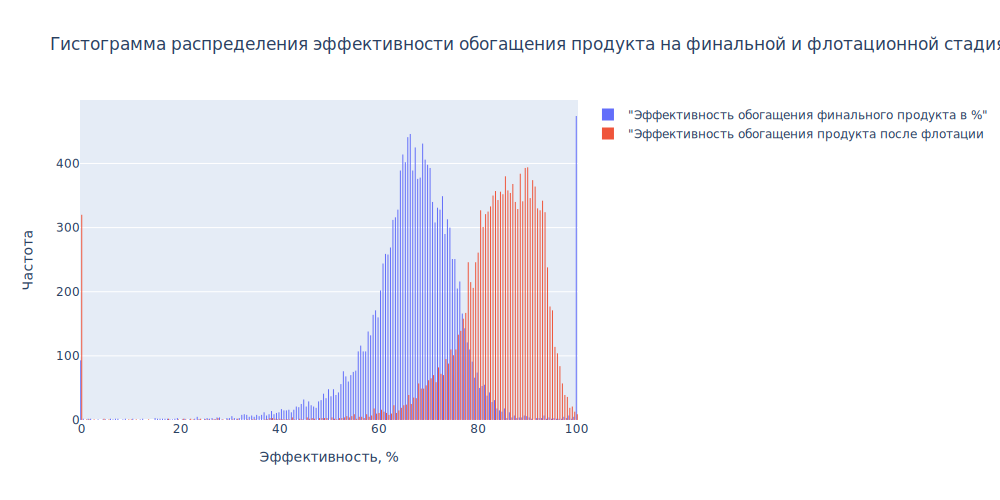

In [23]:
fig = go.Figure() # создаем оболочку фигуры

fig.add_trace(go.Histogram(x=df_train['final.output.recovery'], name='"Эффективность обогащения финального продукта в %"'))
fig.add_trace(go.Histogram(x=df_train['rougher.output.recovery'], name='"Эффективность обогащения продукта после флотации в %"'))


fig.update_layout(barmode='group', 
                  title='Гистограмма распределения эффективности обогащения продукта на финальной и флотационной стадиях',
                  xaxis_title='Эффективность, %', yaxis_title='Частота')
fig.show('svg', width=1000, height=500)

Полученная гистограмма показывает, что для обоих целевых признаков имеются ситуации, когда эффективность обогащения нулевая. Скорей всего это аномалии, связанные с качеством поступившего концетрата в обработку, в нем просто отсутствовало золото. Такие ситуации должны исключаться на обогатительной фабрике, и если мы включим их в модель, то будет искажаться предсказание для всех остальных данных. Нулевые аномалии необходимо удалить.

Также на гистограмме виден скачок для 100 % обогащения на финальном этапе. Это объяняется тем, что 1-я стадия очистки прошла полностью успешно и во время 2-й стадии ничего не вымылось в хвосты. Такие ситуации будем оставлять в датасете.

Необходимо провести удаление 0 и NaN из целевых признаков. Но перед удалением этих строк необходимо провести заполнение пропусков в обучающих признаках. Как сказано в задании от заказчика, соседние данные часто похожи, поэтому недостающие показатели можно заполнить теми, которые идут перед ними. Возможна ситуация, когда в качестве заполняющей будет выбрана та строка, где целевой признак = NaN или 0. Если удалить такие строки на данном этапе, мы потеряем наиболее актуальную информацию для заполнения ряда значений в обучающих признаках.

Для заполнения отсутствующих данных в обуающих признаках воспользуемся методом «ffill», он означает «прямое заполнение» и будет распространять последнее действительное наблюдение вперед. При этом наиболее правильным будет заполнить общий датасет, т.к. в нем содержатся все данные, идущие друг за другом, а далее эти же данные записать в трейн и тест.

In [24]:
# найдем пример для проверки верности заполнения

# предварительно отсортируем датасеты по дате
df_train.sort_values(by='date', inplace=True)
df_full.sort_values(by='date', inplace=True)
df_test.sort_values(by='date', inplace=True)
df_full.sample(5)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
12053,2017-05-31 04:59:59,7.354,9.296,6.438,15.219,81.062,12.509,5.647,8.762,9.790,99.989,12.384,6.380,NaN,8.730,7.415,3.960,31.563,17.604,5.245,7.208,16.232,1505.735,-500.354,1500.150,-500.310,1500.344,-499.008,1499.200,-512.352,33361.604,2789.848,2790.098,2.082,14.238,6.617,249.664,48.978,35.267,13.773,10.000,2.600,10.002,2.600,12.766,8.059,30.124,18.776,NaN,NaN,1.615,NaN,NaN,999.990,-300.106,1201.203,-499.969,1199.805,-500.042,1099.234,-501.109,998.908,-500.188,899.982,-500.162,17.075,6.665,12.907,16.454,25.040,-500.203,19.919,-499.942,30.008,-500.508,20.006,-500.233,20.069,-499.297,9.882,-499.684,14.975,-500.450,10.024,-500.248,14.980,-500.698
6881,2016-10-27 16:59:59,4.023,8.481,13.122,45.334,75.893,10.008,2.583,10.398,3.253,151.447,6.459,6.950,0.692,6.651,8.201,8.952,27.496,14.461,2.411,9.928,2.570,1631.170,-500.213,1701.999,-500.171,1699.098,-500.548,1700.245,-499.857,40142.143,3569.499,3569.075,2.977,9.482,3.697,433.664,43.404,35.712,11.008,14.998,6.000,15.002,5.999,11.032,6.385,27.881,22.711,90.801,6.740,0.360,19.111,1.809,986.886,-500.338,1471.51

При взятии случайных 5-ти строк в общей выборке в строке 22358 выявлены NaN. Выведем несколько строк в этом диапазоне.

In [25]:
df_full.loc[22355:22360,]

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
22355,2018-08-03 10:59:59,0.010,0.010,0.010,0.010,100.000,0.000,0.000,0.000,0.000,NaN,NaN,7.280,0.007,0.010,0.010,0.010,0.010,0.000,0.000,0.000,0.000,1626.481,-764.262,1800.420,-799.925,796.438,-687.788,2181.129,-797.984,-35.629,-9.179,-3.101,1.000,0.010,0.010,0.091,46.700,0.010,0.010,NaN,NaN,NaN,NaN,0.010,0.010,0.010,0.010,NaN,NaN,0.000,NaN,NaN,1208.486,-651.271,1110.405,-645.901,1130.444,-629.227,1390.738,-593.920,1940.662,-608.475,1065.121,-538.369,0.000,0.000,0.000,0.000,5.059,-625.331,0.099,-798.338,0.000,-789.839,0.000,-515.390,0.000,-799.709,0.000,-508.674,0.453,-646.747,0.508,-765.010,0.249,-555.660
22356,2018-08-03 11:59:59,0.010,0.010,0.010,0.010,100.000,0.000,0.000,0.000,0.000,1.687,NaN,7.280,NaN,0.010,0.010,0.010,0.010,0.000,0.000,0.000,0.000,1650.267,-772.261,1650.750,-799.968,1649.350,-499.229,1643.398,-365.477,6531.542,-8.943,-1.471,1.000,0.010,0.010,0.028,46.702,0.010,0.010,NaN,0.000,NaN,NaN,0.010,0.010,0.010,0.010,NaN,NaN,0.000,NaN,NaN,1293.316,-652.597,1191.078,-607.882,1093.221,-632.386,1009.785,-635.487,899.692,-647.550,900.653,-645.615

При верной отработке методом ffill в строке 22358 в столбце 'primary_cleaner.input.sulfate' должно появиться значение 0.180.

In [26]:
row_test_columns = df_test.columns
train_columns = df_train.columns.tolist()
train_columns.remove('final.output.recovery')
train_columns.remove('rougher.output.recovery')

In [27]:
df_full[train_columns] = df_full[train_columns].ffill(axis = 0) # заполняем только по обучающим признакам
df_full.loc[22355:22360,]

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
22355,2018-08-03 10:59:59,0.010,0.010,0.010,0.010,100.000,0.000,0.000,0.000,0.000,166.078,14.986,7.280,0.007,0.010,0.010,0.010,0.010,0.000,0.000,0.000,0.000,1626.481,-764.262,1800.420,-799.925,796.438,-687.788,2181.129,-797.984,-35.629,-9.179,-3.101,1.000,0.010,0.010,0.091,46.700,0.010,0.010,9.602,5.627,9.608,5.641,0.010,0.010,0.010,0.010,NaN,6.285,0.000,15.505,1.745,1208.486,-651.271,1110.405,-645.901,1130.444,-629.227,1390.738,-593.920,1940.662,-608.475,1065.121,-538.369,0.000,0.000,0.000,0.000,5.059,-625.331,0.099,-798.338,0.000,-789.839,0.000,-515.390,0.000,-799.709,0.000,-508.674,0.453,-646.747,0.508,-765.010,0.249,-555.660
22356,2018-08-03 11:59:59,0.010,0.010,0.010,0.010,100.000,0.000,0.000,0.000,0.000,1.687,14.986,7.280,0.007,0.010,0.010,0.010,0.010,0.000,0.000,0.000,0.000,1650.267,-772.261,1650.750,-799.968,1649.350,-499.229,1643.398,-365.477,6531.542,-8.943,-1.471,1.000,0.010,0.010,0.028,46.702,0.010,0.010,9.602,0.000,9.608,5.641,0.010,0.010,0.010,0.010,NaN,6.285,0.000,15.505,1.745,1293.316,-652.597,1191.078,-607.882,1093.221,-632.386,1009.785,-6

In [28]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                22716 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         22716 non-null  float64       
 2   final.output.concentrate_pb                         22716 non-null  float64       
 3   final.output.concentrate_sol                        22716 non-null  float64       
 4   final.output.concentrate_au                         22716 non-null  float64       
 5   final.output.recovery                               20753 non-null  float64       
 6   final.output.tail_ag                                22716 non-null  float64       
 7   final.output.tail_pb                                22716 non-null  float64       
 8   final.

Видим, что пропуски в обучающих признаках заполнены корректно, целевые признаки не тронуты. Выполним заполнение данных в остальных датасетах. Для этого в качестве индекса сделаем столбы с датами во всех датасетах и заполним пропуски методом update.

In [29]:
# примем дату в качестве индекса
df_full = df_full.set_index('date')
df_test = df_test.set_index('date')
df_train = df_train.set_index('date')

In [30]:
# найдем NaN в обучающей выборке
df_train.sample(10)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-14 21:59:59,4.563,10.685,8.812,45.852,65.949,9.987,2.783,9.586,3.541,186.084,9.976,7.130,0.901,6.987,11.660,10.239,36.135,21.200,5.739,6.219,4.789,1700.237,-499.962,1699.340,-500.365,1699.849,-499.434,1701.577,-469.970,41994.064,2481.722,2481.311,1.993,8.636,4.539,603.248,61.466,38.763,9.045,12.537,7.000,12.535,6.998,11.691,8.709,31.758,20.862,90.202,4.858,0.867,18.343,1.456,1402.981,-300.001,1202.472,-500.116,1099.614,-500.304,1042.724,-500.310,1050.802,-500.094,1000.933,-500.836,16.370,10.372,1.331,8.193,35.028,-499.913,26.962,-499.792,27.964,-500.260,19.001,-500.102,23.010,-500.629,15.104,-500.244,17.961,-500.095,11.984,-500.989,12.002,-500.146
2017-07-01 10:59:59,5.120,10.517,7.486,44.871,60.346,7.088,2.461,10.542,2.338,87.097,5.371,7.560,0.495,8.130,10.347,8.118,33.457,12.916,1.834,7.618,2.903,1699.267,-500.406,1697.833,-499.885,1701.195,-500.507,1699.396,-500.037,47023.745,6712.152,6712.433,2.165,6.690,2.523,364.942,52.951,38.014,5.463,15.000,4.401,15.000,4.

In [31]:
df_train.loc['2018-01-09 00:59:59':'2018-01-09 05:59:59', ]

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-09 00:59:59,0.000,0.000,0.000,0.000,NaN,0.000,0.000,0.000,0.000,NaN,NaN,7.700,0.011,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-782.507,0.000,-800.004,0.000,-799.975,0.000,-799.805,-1262870.148,-0.829,0.162,NaN,0.000,0.000,0.021,28.388,0.000,0.000,NaN,0.003,0.001,NaN,0.000,0.000,0.000,0.000,NaN,NaN,0.000,NaN,NaN,-0.024,-657.861,-0.233,-650.191,-0.012,-633.186,-0.510,-636.332,-1.940,-634.342,-2.343,-649.921,0.000,0.000,0.000,0.000,4.625,-790.078,0.023,-799.724,0.000,-799.583,0.000,-809.158,0.000,-799.641,0.007,-799.799,0.369,-796.360,0.555,-799.997,0.212,-804.509
2018-01-09 01:59:59,0.000,0.000,0.000,0.000,NaN,0.000,0.000,0.000,0.000,NaN,NaN,7.700,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-782.496,0.000,-800.008,0.000,-799.975,0.000,-799.804,-537608.242,-1.213,0.597,NaN,0.000,0.000,0.019,28.389,0.000,0.000,NaN,0.003,NaN,NaN,0.000,0.000,0.000,0.000,NaN,NaN,0.000,NaN,NaN,-0.019,-657.857,-0.258,-650.192,-0.016,-633.110,-0.516,-636.087,-1.932

В случае успешного заполнения в строке с датой 2018-01-09 01:59:59 в столбце primary_cleaner.input.xanthate должно появиться верное значение 0.011.

In [32]:
df_train.update(df_full)
df_train.loc['2018-01-09 00:59:59':'2018-01-09 05:59:59', ]

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-09 00:59:59,0.000,0.000,0.000,0.000,NaN,0.000,0.000,0.000,0.000,0.004,0.002,7.700,0.011,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-782.507,0.000,-800.004,0.000,-799.975,0.000,-799.805,-1262870.148,-0.829,0.162,2.201,0.000,0.000,0.021,28.388,0.000,0.000,0.001,0.003,0.001,1.079,0.000,0.000,0.000,0.000,NaN,5.015,0.000,15.417,1.995,-0.024,-657.861,-0.233,-650.191,-0.012,-633.186,-0.510,-636.332,-1.940,-634.342,-2.343,-649.921,0.000,0.000,0.000,0.000,4.625,-790.078,0.023,-799.724,0.000,-799.583,0.000,-809.158,0.000,-799.641,0.007,-799.799,0.369,-796.360,0.555,-799.997,0.212,-804.509
2018-01-09 01:59:59,0.000,0.000,0.000,0.000,NaN,0.000,0.000,0.000,0.000,0.004,0.002,7.700,0.011,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-782.496,0.000,-800.008,0.000,-799.975,0.000,-799.804,-537608.242,-1.213,0.597,2.201,0.000,0.000,0.019,28.389,0.000,0.000,0.001,0.003,0.001,1.079,0.000,0.000,0.000,0.000,NaN,5.015,0.000,15.417,1.995,-0.019,-657.857,-0.258,-650.192,

In [33]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16860 non-null  float64
 1   final.output.concentrate_pb                         16860 non-null  float64
 2   final.output.concentrate_sol                        16860 non-null  float64
 3   final.output.concentrate_au                         16860 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16860 non-null  float64
 6   final.output.tail_pb                                16860 non-null  float64
 7   final.output.tail_sol                               16860 non-null  float64
 8   final.output.tail_au                     

Пропуски в трейне заполнены корректно, аналогично заполняем тестовую выборку и добавляем к ней целевые признаки.

In [34]:
df_test.update(df_full)
df_test['final.output.recovery'] = df_full['final.output.recovery']
df_test['rougher.output.recovery'] = df_full['rougher.output.recovery']

In [35]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5856 non-null   float64
 1   primary_cleaner.input.depressant            5856 non-null   float64
 2   primary_cleaner.input.feed_size             5856 non-null   float64
 3   primary_cleaner.input.xanthate              5856 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5856 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5856 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5856 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5856 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5856 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5856 

Пропуски в тестовом датасете заполнены. Проверим, что целевые признаки притянулись правильно.

In [36]:
df_test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery,rougher.output.recovery
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.801,14.993,8.080,1.005,1398.981,-500.226,1399.145,-499.920,1400.103,-500.704,1399.002,-499.485,13.129,5.637,489.794,62.710,42.022,12.084,16.923,6.153,16.868,6.151,1001.849,-350.301,1249.739,-399.108,1249.751,-399.397,1198.288,-399.489,999.472,-399.531,949.566,-398.181,24.938,-500.491,14.948,-500.014,20.018,-450.396,13.987,-449.832,12.024,-497.796,8.017,-501.289,7.947,-432.318,4.873,-500.037,26.706,-499.709,70.274,89.993
2016-09-01 01:59:59,215.392,14.987,8.080,0.990,1398.778,-500.057,1398.055,-499.778,1396.151,-499.240,1399.508,-500.416,13.036,5.526,490.105,61.961,41.188,11.919,17.003,5.999,16.996,6.002,998.691,-350.426,1248.395,-399.946,1249.514,-399.631,1200.506,-399.942,1000.002,-399.492,950.200,-405.788,24.923,-499.814,14.931,-500.764,19.989,-450.114,14.093,-450.059,12.058,-498.696,8.131,-499.634,7.958,-525.840,4.879,-500.162,25.020,-499.819,68.910,88.090
2016-09-01 02:59:59,215.260,12.885,7.787,0.996,1398.494,-500.868,1398.860,-499.765,1398.076,-502.152,1399.497,-499.715,13.138,5.427,489.618,66.904,42.546,12.091,16.993,5.851,16.982,5.854,998.517,-349.784,1247.441,-400.264,1248.207,-401.074,1199.770,-400.791,999.926,-399.237,950.320,-400.864,24.909,-500.304,14.997,-500.994,20.040,-450.263,14.078,-449.661,11.962,-498.767,8.097,-500.827,8.071,-500.802,4.905,-499.829,24.995,-500.623,68.143,88.413
2016-09-01 03:59:59,215.336,12.007,7.640,0.864,1399.618,-498.864,1397.440,-499.211,1400.129,-498.356,1401.065,-501.039,12.401,5.115,476.618,59.866,41.060,12.182,16.532,5.802,16.515,5.804,1000.277,-350.173,1251.323,-398.655,1250.494,-399.747,1199.399,-397.503,1001.931,-400.438,950.735,-399.803,24.894,-499.382,14.917,-499.862,20.031,-449.373,14.014,-449.527,12.033,-498.351,8.075,-499.474,7.897,-500.869,4.931,-499.964,24.949,-498.710,67.776,87.360
2016-09-01 04:59:59,199.099,10.683,7.530,0.806,1401.268,-500.808,1398.129,-499.505,1402.172,-500.811,1399.481,-499.374,11.327,4.767,488.248,63.315,41.269,11.290,13.607,5.738,13.650,5.740,996.541,-350.563,1304.659,-399.512,1306.45

In [37]:
df_full.loc['2016-09-01 00:59:59':'2016-09-01 04:59:59']

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,7.578,10.466,11.991,40.744,70.274,12.689,3.844,11.076,4.538,210.801,14.993,8.080,1.005,11.632,12.707,17.872,28.365,17.266,4.148,11.035,6.588,1398.981,-500.226,1399.145,-499.920,1400.103,-500.704,1399.002,-499.485,35236.090,2173.703,2102.439,2.144,13.129,5.637,489.794,62.710,42.022,12.084,16.923,6.153,16.868,6.151,15.735,8.227,33.792,22.186,89.993,5.936,0.747,14.788,2.372,1001.849,-350.301,1249.739,-399.108,1249.751,-399.397,1198.288,-399.489,999.472,-399.531,949.566,-398.181,16.485,4.414,12.034,5.561,24.938,-500.491,14.948,-500.014,20.018,-450.396,13.987,-449.832,12.024,-497.796,8.017,-501.289,7.947,-432.318,4.873,-500.037,26.706,-499.709
2016-09-01 01:59:59,7.814,10.581,12.216,39.604,68.910,12.829,3.919,11.133,4.675,215.392,14.987,8.080,0.990,11.563,12.587,18.063,27.175,18.179,4.640,10.995,7.122,1398.778,-500.057,1398.055,-499.778,1396.151,-499.240,1399.508,-500.416,40677.566,2812.793,2816.389,2.157,13.036,5.526,490.105,61.961,41.188,11.919,17.003,5.9

Пропуски в обучающих признаках заполнены во всех датасетах, в тестовый датасет добавлены целевые признаки. На последнем этапе удалим строки с целевыми признаками, значения которых пропущены или равны 0.

In [38]:
target = ['final.output.recovery', 'rougher.output.recovery']
df_full = df_full.dropna(subset=target)
df_full = df_full.loc[(df_full['final.output.recovery'] > 0) & (df_full['rougher.output.recovery'] > 0)]
df_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18949 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         18949 non-null  float64
 1   final.output.concentrate_pb                         18949 non-null  float64
 2   final.output.concentrate_sol                        18949 non-null  float64
 3   final.output.concentrate_au                         18949 non-null  float64
 4   final.output.recovery                               18949 non-null  float64
 5   final.output.tail_ag                                18949 non-null  float64
 6   final.output.tail_pb                                18949 non-null  float64
 7   final.output.tail_sol                               18949 non-null  float64
 8   final.output.tail_au                     

In [39]:
df_train = df_train.dropna(subset=target)
df_train = df_train.loc[(df_train['final.output.recovery'] > 0) & (df_train['rougher.output.recovery'] > 0)]

In [40]:
df_test = df_test.dropna(subset=target)
df_test = df_test.loc[(df_test['final.output.recovery'] > 0) & (df_test['rougher.output.recovery'] > 0)]

In [41]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13795 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         13795 non-null  float64
 1   final.output.concentrate_pb                         13795 non-null  float64
 2   final.output.concentrate_sol                        13795 non-null  float64
 3   final.output.concentrate_au                         13795 non-null  float64
 4   final.output.recovery                               13795 non-null  float64
 5   final.output.tail_ag                                13795 non-null  float64
 6   final.output.tail_pb                                13795 non-null  float64
 7   final.output.tail_sol                               13795 non-null  float64
 8   final.output.tail_au                     

In [34]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5154 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 54 columns):
primary_cleaner.input.sulfate                 5154 non-null float64
primary_cleaner.input.depressant              5154 non-null float64
primary_cleaner.input.feed_size               5154 non-null float64
primary_cleaner.input.xanthate                5154 non-null float64
primary_cleaner.state.floatbank8_a_air        5154 non-null float64
primary_cleaner.state.floatbank8_a_level      5154 non-null float64
primary_cleaner.state.floatbank8_b_air        5154 non-null float64
primary_cleaner.state.floatbank8_b_level      5154 non-null float64
primary_cleaner.state.floatbank8_c_air        5154 non-null float64
primary_cleaner.state.floatbank8_c_level      5154 non-null float64
primary_cleaner.state.floatbank8_d_air        5154 non-null float64
primary_cleaner.state.floatbank8_d_level      5154 non-null float64
rougher.input.feed_ag                    

По итогу 1-го этапа сделано следующее:
    
    1.	Выявлено и объяснено отсутствие ряда признаков в тестовой выборке. Основная причина – они характеризуют готовый продукт на определенной стадии, что никак не может быть получено во время технологического процесса.
    
    2.	Выявлены и обработаны пропуски. Пропуски в обучающих признаках в полном датасете заполнены ближними данными методом ffill, в тестовом и обучающем наборах – заполнены из полной выборки методом update. Пропуски в целевых признаках удалены.
    
    3.	Выявлены нулевые значения в целевых признаках. Такие значения приняты некорректными, строки с ними удалены.
    
    4.	В тестовую выборку добавлены целевые признаки.
    
    5.	Выполнена проверка расчитанной в датасете эффективности обогащения. Получено пренебрежительно малое MAE, которое подтвердило правильность рассчитанных признаков.

## 3 Анализ данных

### 3.1 Анализ изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки.

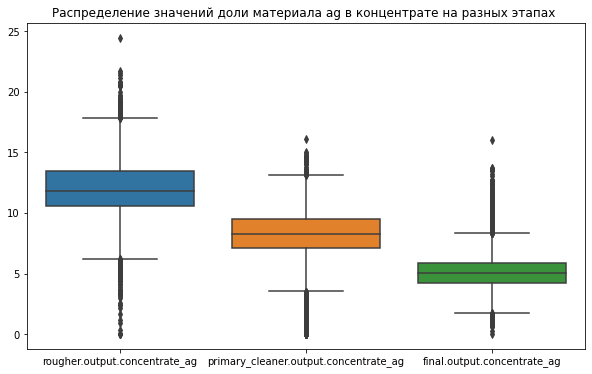

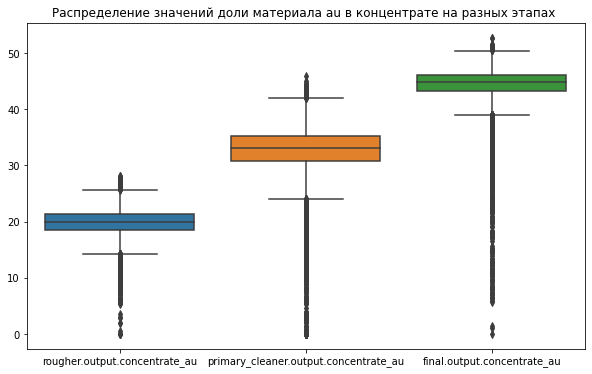

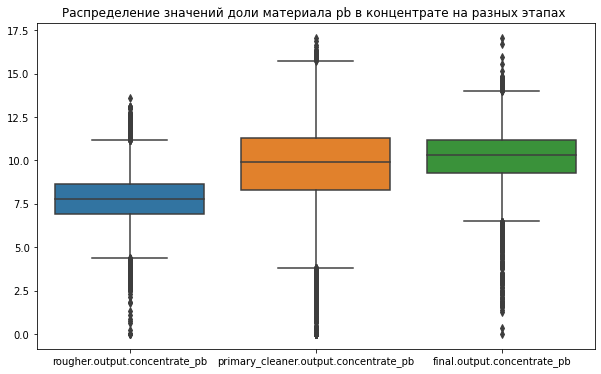

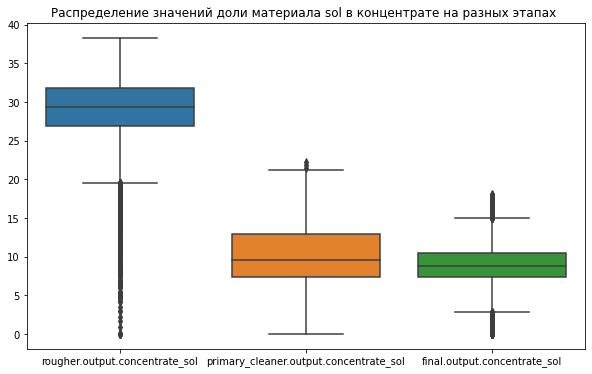

In [42]:
concentrate = {'ag':['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag' ],
               'au':['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au' ],
               'pb':['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb' ],
               'sol':['rougher.output.concentrate_sol', 'primary_cleaner.output.concentrate_sol', 'final.output.concentrate_sol']}
 
for key in concentrate:
    plt.figure(figsize=(10,6))
    sns.boxplot(data = df_train[concentrate[key]])
    plt.title(f'Распределение значений доли материала {key} в концентрате на разных этапах ')
    plt.show()

Опишем изменения концентраций каждого материала в зависимости от этапа.

AU - золото. Концентрация золота закономерно возрастает от начального к конечному этапу - средние значения на финальном этапе находятся в районе 45 %, а это является самой большой величиной в концентрате. Изменение этих боксплотов закономерно показывает, что процесс идет успешно.

AG - серебро. Концентрация серебра планомерно снижается в процессе обогащения, скорей всего происходит его вымывание из раствора на различных стадиях процесса. На финальном этапе среднее значение концентрации данного материала составляет около 5 %.

PB - свинец. Концентрация свинца меняется незначительно в процессе обогащения, средние значения изменяются от 7.5 до 10 %. Предположительно, в процессе первичной очистки в раствор искусственно добавляется данный материал и далее не меняется.

SOL - прочие примеси. Содержание прочих примесей особо велико после флотации, но при первичной очистке оно резко падает (средние значения уменьшаются в 3 раза), вторичная очистка не дает такого эффекта и содержание примесей в растворе почти не меняется.

### 3.2 Сравнение распределения гранул сырья на обучающей и тестовых выборках

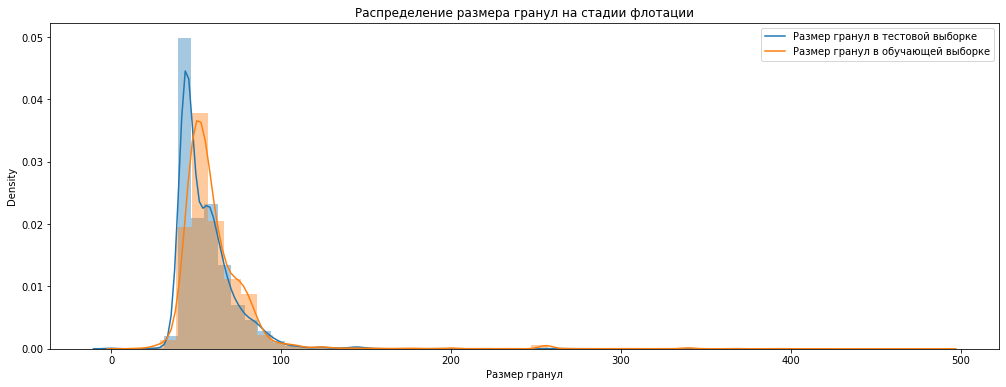

In [43]:
fig = plt.figure(figsize=(17,6))
sns.distplot(df_test['rougher.input.feed_size'])
sns.distplot(df_train['rougher.input.feed_size'])
plt.title('Распределение размера гранул на стадии флотации')
plt.xlabel('Размер гранул')
plt.legend(labels=['Размер гранул в тестовой выборке','Размер гранул в обучающей выборке'])
plt.show()

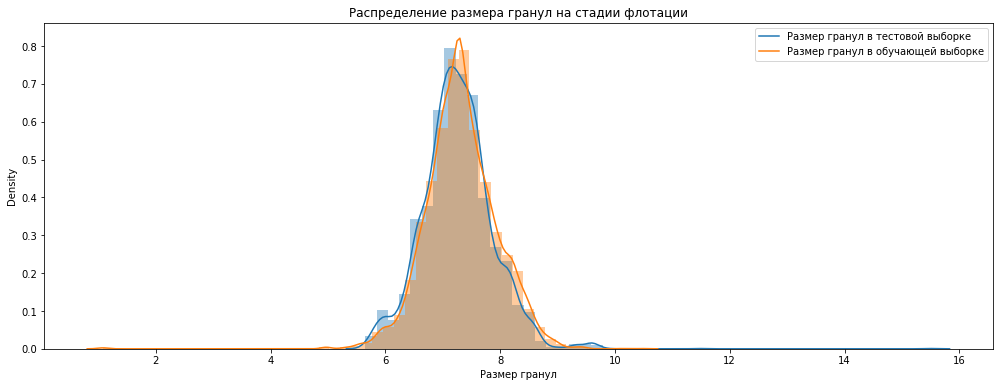

In [44]:
fig = plt.figure(figsize=(17,6))
sns.distplot(df_test['primary_cleaner.input.feed_size'])
sns.distplot(df_train['primary_cleaner.input.feed_size'])
plt.title('Распределение размера гранул на стадии флотации')
plt.xlabel('Размер гранул')
plt.legend(labels=['Размер гранул в тестовой выборке','Размер гранул в обучающей выборке'])
plt.show()

Нормализованные гистограммы показали, что распределения размеров гранул сырья на обучающей и тестовых выборках не имеют значительных отличий. Также стоит отметить, что перед первичной очисткой размер гранул снижается практически в 10 раз, что говорит о их расщеплении во время флотации.

### 3.3 Исследование суммарной концентрации веществ

Исследование суммарных концентраций проведем в общем датасете. Посчитаем концентрации и построим по ним гистограммы для выявления аномалий.

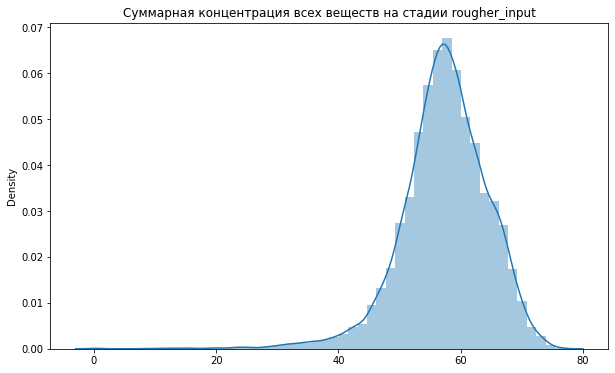

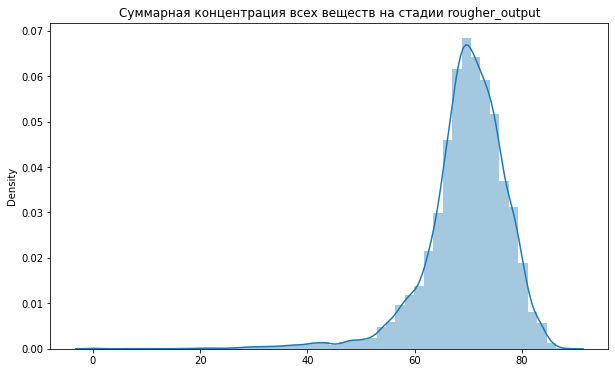

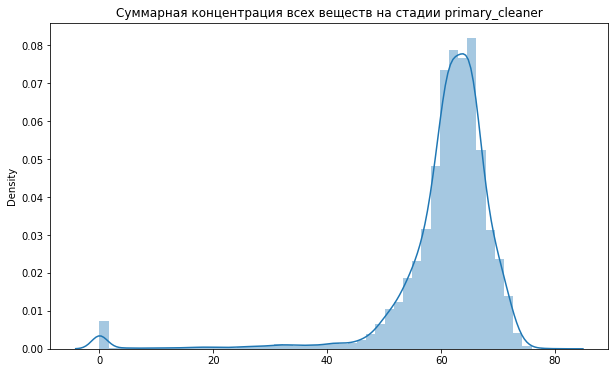

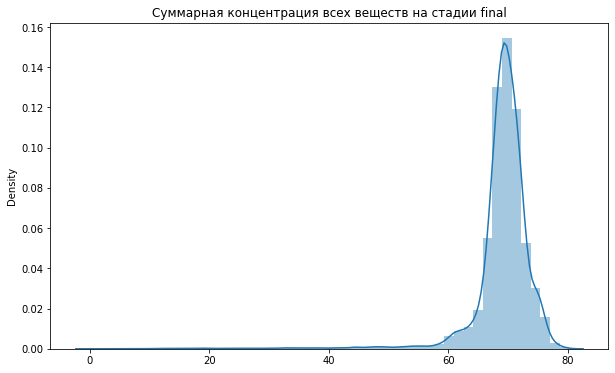

In [45]:
sum_concentrate = {'rougher_input':['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_au'],
    'rougher_output':[x for x in df_full.columns if x.startswith('rougher.output.concentrate')],
               'primary_cleaner':[x for x in df_full.columns if x.startswith('primary_cleaner.output.concentrate')],
               'final':[x for x in df_full.columns if x.startswith('final.output.concentrate')]
                  }
 
for key in sum_concentrate:
 
    plt.figure(figsize=(10,6))
    sns.distplot(np.sum(df_full[sum_concentrate[key]], axis = 1))
    plt.title(f'Суммарная концентрация всех веществ на стадии {key}')
    plt.show()

Из полученных диаграмм плотности видно следующие моменты:
1. Суммарная концентрация веществ увеличивается с течением процесса обогащения (колокол как бы сдвигается вправо по шкале), что закономерно, т.к. при обработке вымываются лишние примеси и подсадочные реагенты.
2. Замечены колебания при нулевых значениях, для первичной очистки это проявляется существенно, для остальных стадий - незначительно. Скорей эти значения получены в те моменты времени когда производственный процесс по каким-либо причинам был остановлен, поэтому такие строки должны быть удалены из датасетов.

Удалим аномальные нули.

In [46]:
for key in sum_concentrate:
    stage_sum_conc = df_full[sum_concentrate[key]].sum(axis=1)
    display(df_full[stage_sum_conc == 0]['final.output.concentrate_ag'].count())
    df_full = df_full[stage_sum_conc > 0]
df_full.info()

0

0

101

0

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18848 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         18848 non-null  float64
 1   final.output.concentrate_pb                         18848 non-null  float64
 2   final.output.concentrate_sol                        18848 non-null  float64
 3   final.output.concentrate_au                         18848 non-null  float64
 4   final.output.recovery                               18848 non-null  float64
 5   final.output.tail_ag                                18848 non-null  float64
 6   final.output.tail_pb                                18848 non-null  float64
 7   final.output.tail_sol                               18848 non-null  float64
 8   final.output.tail_au                     

Из общей выборки аномалии удалены, теперь уберем их в тесте и трейне.

In [47]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13795 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         13795 non-null  float64
 1   final.output.concentrate_pb                         13795 non-null  float64
 2   final.output.concentrate_sol                        13795 non-null  float64
 3   final.output.concentrate_au                         13795 non-null  float64
 4   final.output.recovery                               13795 non-null  float64
 5   final.output.tail_ag                                13795 non-null  float64
 6   final.output.tail_pb                                13795 non-null  float64
 7   final.output.tail_sol                               13795 non-null  float64
 8   final.output.tail_au                     

In [48]:
df_train = df_train.merge(df_full, how='inner')

In [49]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13725 entries, 0 to 13724
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         13725 non-null  float64
 1   final.output.concentrate_pb                         13725 non-null  float64
 2   final.output.concentrate_sol                        13725 non-null  float64
 3   final.output.concentrate_au                         13725 non-null  float64
 4   final.output.recovery                               13725 non-null  float64
 5   final.output.tail_ag                                13725 non-null  float64
 6   final.output.tail_pb                                13725 non-null  float64
 7   final.output.tail_sol                               13725 non-null  float64
 8   final.output.tail_au                                13725 non-null  float64


In [43]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5154 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 54 columns):
primary_cleaner.input.sulfate                 5154 non-null float64
primary_cleaner.input.depressant              5154 non-null float64
primary_cleaner.input.feed_size               5154 non-null float64
primary_cleaner.input.xanthate                5154 non-null float64
primary_cleaner.state.floatbank8_a_air        5154 non-null float64
primary_cleaner.state.floatbank8_a_level      5154 non-null float64
primary_cleaner.state.floatbank8_b_air        5154 non-null float64
primary_cleaner.state.floatbank8_b_level      5154 non-null float64
primary_cleaner.state.floatbank8_c_air        5154 non-null float64
primary_cleaner.state.floatbank8_c_level      5154 non-null float64
primary_cleaner.state.floatbank8_d_air        5154 non-null float64
primary_cleaner.state.floatbank8_d_level      5154 non-null float64
rougher.input.feed_ag                    

In [50]:
df_test = df_test.merge(df_full[df_test.columns], how='inner')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5123 entries, 0 to 5122
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5123 non-null   float64
 1   primary_cleaner.input.depressant            5123 non-null   float64
 2   primary_cleaner.input.feed_size             5123 non-null   float64
 3   primary_cleaner.input.xanthate              5123 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5123 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5123 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5123 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5123 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5123 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5123 non-null   float64
 10  primary_clea

По итогу проведенного анализа выявлено следующее:
    
1.	Концентрация основного элемента (золота) закономерно возрастает в процессе обогащения. Концентрация серебра и прочих примесей закономерно падает по ходу технологического процесса. Концентрация свинца практически не меняется, что скорей всего обусловлено необходимостью дальнейшей более кропотливой обработки финального продукта.
2.	Распределения размеров гранул сырья на обучающей и тестовых выборках не имеют значительных отличий. Перед первичной очисткой размер гранул снижается практически в 10 раз, что говорит о их расщеплении во время флотации.
3.	Суммарная концентрация веществ увеличивается с течением процесса обогащения (колокол как бы сдвигается вправо по шкале), что закономерно, т.к. при обработке вымываются лишние примеси и подсадочные реагенты.
4.	На стадии первичной очистки были выявлены аномалии (101 строка), когда суммарная концентрация равнялась нулю. Скорей всего, процесс обогащения был остановлен в это время, поэтому такие данные участвовать в модели не должны и были удалены из всех выборок.

## 4 Модель

### 4.1 Создание функции для вычисления итоговой sMAPE

In [51]:
def smape (target, predictions):
    numerator = abs(predictions - target)
    denominator = (abs(target) + abs(predictions)) / 2
    summa = (numerator / denominator).sum()
    smape = (1 / len(target)) * summa * 100
    return smape

### 4.2 Обучение моделей

Предварительно проведем разделение модели на признаки и их масштабирование.

In [52]:
# подготовим список признаков для этапа флотации
features_rougher = []
for column in row_test_columns:
    if "rougher" in column:
        features_rougher.append(column)

train_features_rougher = df_train[features_rougher]
train_target_rougher = df_train['rougher.output.recovery']
display(train_features_rougher.head())
display(train_target_rougher.head())

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
0,6.100,2.285,523.546,55.487,36.809,6.486,11.987,6.008,11.837,6.006,999.707,-404.067,1603.011,-434.715,1602.375,-442.204,1598.937,-451.294,1404.472,-455.463,1416.355,-451.940
1,6.161,2.266,525.291,57.279,35.753,6.479,11.971,6.006,11.996,6.013,1000.286,-400.065,1600.755,-449.953,1600.480,-449.831,1600.528,-449.954,1399.227,-450.870,1399.720,-450.119
2,6.116,2.160,530.027,57.511,35.972,6.362,11.921,6.197,11.920,6.205,999.720,-400.074,1599.337,-450.009,1599.673,-449.954,1599.849,-449.954,1399.181,-449.938,1400.317,-450.527
3,6.043,2.038,542.590,57.793,36.862,6.118,11.630,6.203,11.692,6.197,999.815,-400.200,1600.059,-450.620,1600.013,-449.910,1597.725,-450.130,1400.943,-450.030,1400.235,-449.791
4,6.061,1.787,540.532,56.047,34.348,5.664,10.958,6.199,10.961,6.195,999.679,-399.753,1600.209,-449.600,1600.358,-450.034,1599.759,-449.910,1401.561,-448.877,1401.160,-450.407


0   87.108
1   86.843
2   86.842
3   87.226
4   86.689
Name: rougher.output.recovery, dtype: float64

In [53]:
# подготовим признаки для финального этапа
train_features_final = df_train[df_test.columns].drop(['rougher.output.recovery','final.output.recovery'], axis=1)
train_target_final = df_train['final.output.recovery']
display(train_features_final.head())
display(train_target_final.head())

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,127.092,10.128,7.250,0.989,1549.776,-498.912,1551.434,-516.403,1549.874,-498.667,1554.367,-493.428,6.100,2.285,523.546,55.487,36.809,6.486,11.987,6.008,11.837,6.006,999.707,-404.067,1603.011,-434.715,1602.375,-442.204,1598.937,-451.294,1404.472,-455.463,1416.355,-451.940,25.853,-498.526,23.894,-501.406,23.962,-495.263,21.940,-499.341,14.017,-502.488,12.100,-504.716,9.926,-498.310,8.080,-500.471,14.151,-605.842
1,125.629,10.296,7.250,1.003,1576.167,-500.905,1575.951,-499.866,1575.994,-499.315,1574.479,-498.932,6.161,2.266,525.291,57.279,35.753,6.479,11.971,6.006,11.996,6.013,1000.286,-400.065,1600.755,-449.953,1600.480,-449.831,1600.528,-449.954,1399.227,-450.870,1399.720,-450.119,25.881,-499.990,23.890,-500.372,23.971,-500.085,22.086,-499.447,13.992,-505.503,11.951,-501.332,10.039,-500.170,7.985,-500.582,13.998,-599.787
2,123.820,11.316,7.250,0.991,1601.556,-499.998,1600.387,-500.608,1602.004,-500.870,1599.542,-499.827,6.116,2.160,530.027,57.511,35.972,6.362,11.921,6.197,11.920,6.205,999.720,-400.074,1599.337,-450.009,1599.673,-449.954,1599.849,-449.954,1399.181,-449.938,1400.317,-450.527,26.005,-499.930,23.887,-499.952,23.914,-499.442,23.958,-499.902,14.015,-502.521,11.913,-501.133,10.071,-500.129,8.014,-500.518,14.029,-601.427
3,122.270,11.322,7.250,0.997,1599.969,-500.952,1600.659,-499.677,1600.304,-500.728,1600.450,-500.053,6.043,2.038,542.590,57.793,36.862,6.118,11.630,6.203,11.692,6.197,999.815,-400.200,1600.059,-450.620,1600.013,-449.910,1597.725,-450.130,1400.943,-450.030,1400.235,-449.791,25.943,-499.177,23.956,-499.849,23.967,-500.009,23.954,-499.945,14.037,-500.857,12.000,-501.194,9.970,-499.202,7.977,-500.256,14.006,-599.996
4,117.988,11.914,7.250,1.010,1601.340,-498.975,1601.438,-500.323,1599.582,-500.888,1602.650,-500.593,6.061,1.787,540.532,56.047,34.348,5.664,10.958,6.199,10.961,6.195,999.679,-399.753,1600.209,-449.600,1600.358,-450.034,1599.759,-449.910,1401.561,-448.877,1401.160,-450.407,26.025,-500.279,23.955,-500.594,23.986,-500.084,23.959,-499.990,14.027,-499.839,11.953,-501.054,9.926,-501.687,7.894,-500.356,13.997,-601.497


0   70.541
1   69.266
2   68.116
3   68.348
4   66.927
Name: final.output.recovery, dtype: float64

In [54]:
# подготовим тестовые выборки
test_features_rougher = df_test[features_rougher]
test_target_rougher = df_test['rougher.output.recovery']
test_features_final = df_test.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
test_target_final = df_test['final.output.recovery']

In [55]:
# проведем масштабирование признаков этапа флотации
scaler_rougher = StandardScaler()
scaler_rougher.fit(train_features_rougher)

train_col_rougher = train_features_rougher.columns
test_col_rougher = test_features_rougher.columns

train_features_rougher = scaler_rougher.transform(train_features_rougher)
train_features_rougher = pd.DataFrame(train_features_rougher, columns = train_col_rougher)

test_features_rougher = scaler_rougher.transform(test_features_rougher)
test_features_rougher = pd.DataFrame(test_features_rougher, columns = test_col_rougher)

In [56]:
# проведем масштабирование признаков финального этапа

scaler_final = StandardScaler()
scaler_final.fit(train_features_final)

train_col_final = train_features_final.columns
test_col_final = test_features_final.columns

train_features_final = scaler_final.transform(train_features_final)
train_features_final = pd.DataFrame(train_features_final, columns = train_col_final)

test_features_final = scaler_final.transform(test_features_final)
test_features_final = pd.DataFrame(test_features_final, columns = test_col_final)

Создадим функцию для оценки качества модели с помощью кросс-валидации.

In [57]:
def cross_val (model, features, target):
    scores = cross_val_score(model, features, 
                                   target, scoring=make_scorer(smape, greater_is_better=True), cv=5,n_jobs=-1)
    smape_res = np.mean(scores)
    return smape_res

Создадим функцию для автоматического вывода smape каждого этапа и финальной sMAPE.

In [58]:
def ml(model):
    smape_rougher = cross_val (model, train_features_rougher, train_target_rougher)
    smape_final = cross_val (model, train_features_final, train_target_final)
    smape_end = 0.25 * smape_rougher + 0.75 * smape_final
    print('Средняя оценка качества по кросс-валидации на этапе флотации составила', smape_rougher)
    print('Средняя оценка качества по кросс-валидации на финальном этапе составила', smape_final)
    print('Конечная оценка качества по кросс-валидации составила', smape_end)

Спрогнозируем и посчитаем sMAPE с помощью следующих алгоритмов: линейная регрессия, решающее дерево и случайный лес. В качестве проверки успешности моделей сравним их со случайной моделью, для этого применим DummyRegressor.

In [59]:
model = LinearRegression()
ml(model)

Средняя оценка качества по кросс-валидации на этапе флотации составила 6.42016606469822
Средняя оценка качества по кросс-валидации на финальном этапе составила 11.03938048644687
Конечная оценка качества по кросс-валидации составила 9.884576881009707


In [60]:
model = DecisionTreeRegressor()
ml(model)

Средняя оценка качества по кросс-валидации на этапе флотации составила 8.674553028394769
Средняя оценка качества по кросс-валидации на финальном этапе составила 15.789873025113355
Конечная оценка качества по кросс-валидации составила 14.01104302593371


In [61]:
model = RandomForestRegressor()
ml(model)

Средняя оценка качества по кросс-валидации на этапе флотации составила 6.681294169728853
Средняя оценка качества по кросс-валидации на финальном этапе составила 9.648131723982427
Конечная оценка качества по кросс-валидации составила 8.906422335419034


In [62]:
model = DummyRegressor()
ml(model)

Средняя оценка качества по кросс-валидации на этапе флотации составила 7.803961504107102
Средняя оценка качества по кросс-валидации на финальном этапе составила 10.412752300489277
Конечная оценка качества по кросс-валидации составила 9.760554601393734


Видим, что случайный лес имеет наилучшую среднюю оценку качества, но она всего лишь немного лучше нежели если просто все заполнить средними значениями (Dummy). Поэтому попробуем немного поднастроить параметры случайного леса.

In [63]:
best_smape = 10
est_est = 0
best_depth = 0
for est in range(10, 51, 10):
    for depth in range (1, 5):
        model = RandomForestRegressor(n_estimators=est, max_depth=depth)
        smape_rougher = cross_val (model, train_features_rougher, train_target_rougher)
        smape_final = cross_val (model, train_features_final, train_target_final)
        smape_end = 0.25 * smape_rougher + 0.75 * smape_final
        if smape_end < best_smape:
            best_smape = smape_end
            best_est = est
            best_depth = depth
print('Наилучшая модель с sMAPE, равным {}, получена для случайного леса \
с количеством деревьев {} и глубиной {}'.format(best_smape, best_est, best_depth))

Наилучшая модель с sMAPE, равным 8.349729712410555, получена для случайного леса с количеством деревьев 30 и глубиной 4


Проверим модель на тестовой выборке.

In [64]:
# подготовим функцию для проверки на тесте
def ml_test(model):
    model_rougher = model
    model_rougher.fit(train_features_rougher, train_target_rougher)
    predictions_rougher = model_rougher.predict(test_features_rougher)
    

    model_final = model
    model_rougher.fit(train_features_final, train_target_final)
    predictions_final = model_rougher.predict(test_features_final)
    
    smape_rougher = smape(test_target_rougher, predictions_rougher)
    smape_final = smape(test_target_final, predictions_final)
    smape_end = 0.25 * smape_rougher + 0.75 * smape_final
    print('Средняя оценка качества по кросс-валидации на этапе флотации составила', smape_rougher)
    print('Средняя оценка качества по кросс-валидации на финальном этапе составила', smape_final)
    print('Конечная оценка качества по кросс-валидации составила', smape_end)

In [65]:
model = DummyRegressor()
ml_test(model)

Средняя оценка качества по кросс-валидации на этапе флотации составила 5.364780952068203
Средняя оценка качества по кросс-валидации на финальном этапе составила 8.58252552273144
Конечная оценка качества по кросс-валидации составила 7.778089380065631


In [66]:
model = RandomForestRegressor(n_estimators=30, max_depth=4)
ml_test(model)

Средняя оценка качества по кросс-валидации на этапе флотации составила 4.745863039768369
Средняя оценка качества по кросс-валидации на финальном этапе составила 8.284931941221693
Конечная оценка качества по кросс-валидации составила 7.400164715858362


По итогу создания моделей сделано следующее:
    
1.	Подготовлена функция расчета sMAPE.
2.	Подготовлены обучающие и целевые признаки.
3.	Обучающие признаки отмасштабированы.
4.	Подготовлена автоматизированная функция поиска наилучшего sMAPE с помощью кросс-валидации.
5. Наилучшей моделью оказался случайный лес с 30 деревьями и глубиной 4. Финальная sMAPE для данной модели на тестовой выборке составила 7.4.
6. Дамми регрессор хоть незначительно, но побит лучшей моделью, как на трейне так и на тесте.